# POC QIM descision Tree

-- identifies the classes of interest for the tree


In [0]:
import pandas as pd
import numpy as np
import random 
from ast import literal_eval
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils import shuffle
from tabulate import tabulate
import pickle


import pydotplus
from sklearn.datasets import load_iris
from sklearn import tree
import numpy
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
root_directory = os.path.dirname(os.getcwd())

# If google colab is used

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile
root_directory = 'gdrive/My Drive/data_output/TSD/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Process the input data

-- can be used via a dataframe csv 
-- can be used via a p file

In [0]:
from sklearn.model_selection import train_test_split

def generate_ds():
    subset = df[['DARKNESS_classes','RAIN_classes', 'MOTIONBLUR_classes', 'BACKLIGHTSUN_classes']]
    
    X = subset.values
    y = df['VGG_is_correct'].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)
    data_set = {"data":X_train, 
                "feature_names":['DARKNESS', 'RAIN', 'MOTIONBLUR', 'BACKLIGHTSUN'],
                "target_names":"",
                "target":y_train}
    return data_set, X_test, y_test

def generate_ds_from_p_file(pickle_file_path):
    with open (pickle_file_path, mode='rb') as f:
        annotated_data = pickle.load(f)
    X = np.array(list(zip(
                annotated_data['BACKLIGHT'], 
                 annotated_data['DARKNESS'], 
                 annotated_data['DIRTLENS'], 
                 annotated_data['MOTIONBLUR'], 
                 annotated_data['RAIN'])))
    y = np.array(annotated_data['VGG_is_correct'], dtype=np.int)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=33)
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)
    data_set = {"data":X_train, 
                "feature_names":['BACKLIGHSUN', 
                                 'DARKNESS', 
                                 'DIRTLENS', 
                                 'MOTIONBLUR', 
                                 'RAIN'],
                "target_names":"",
                "target":y_train}

    return data_set, X_test, y_test
        


# Generate Classifying Descision Tree 

In [9]:
class DT:
    def __init__(self, dataset):
        self.dataset = dataset
        #self.class_names = class_names
        self.clf = self.train_model()

    def train_model(self):
        """
        Train decision tree classifier

        :param iris:    iris data set instance
        :return:        classifier instance
        """
        clf = tree.DecisionTreeClassifier("gini", 
                                          max_features=None, max_leaf_nodes=15, 
                                          min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None) #splitter='random')
        
        clf = clf.fit(self.dataset['data'], self.dataset['target'])
        
        return clf

    def display_image(self, file_path):
        """
        Displays the decision tree image

        :param clf:     classifier instance
        :param iris:    iris data set instance
        """
        dot_data = tree.export_graphviz(self.clf,
                                        feature_names= self.dataset['feature_names'],
                                        class_names=["0","1"],
                                        filled=False, rounded=False)

        graph = pydotplus.graph_from_dot_data(dot_data)
        display(Image(data=graph.create_png()))
        graph.write_pdf(file_path)


if __name__ == '__main__':
    pickle_file = root_directory + "p_validation_files/VALIDATION_ANNOTATED.p"    
    context_data, X_test, y_test = generate_ds_from_p_file(pickle_file)
    dt = DT(context_data)
    
    # optional if you want
    #dt.display_image("original_tree.pdf")
    y_pred = dt.clf.predict(X_test)
    print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")
    from sklearn.metrics import classification_report, confusion_matrix  
    


Model Accuracy: 88.20 %


In [10]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.4944852941176471

In [11]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    print(len(X))
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(context_data['data'],context_data['target'],dt.clf, show_classification_report=True, show_confusion_matrix=True)

30175
Accuracy:0.852 

Classification report
              precision    recall  f1-score   support

           0       0.53      0.04      0.07      4494
           1       0.86      0.99      0.92     25681

    accuracy                           0.85     30175
   macro avg       0.69      0.52      0.50     30175
weighted avg       0.81      0.85      0.79     30175
 

Confusion matrix
[[  176  4318]
 [  155 25526]] 



# Feature Importance by Relevance

In [12]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from scipy.stats import sem

print(dt.clf.feature_importances_)


[0.06748403 0.04716262 0.04024329 0.18114303 0.66396704]


# Analyse the Results of the DT tree
-- find Entropy (information gain splits)
-- use prediction to make a table of the predictions 

In [14]:

def calculate_metrics(trained_model, tree_type):
    lst_of_lsts = []
    sm = 0 
    parsed_title = ""
    scope_value = 0.981
    for i in range(0,3):     
        for j in range(0,3):
            for k in range(0,3):
                for l in range(0,3):
                    for n in range(0,3):
                        value = (trained_model.predict_proba([[i,j,k,l,n]]))
                        if i > 0:
                            parsed_title = parsed_title + "BACKLIGHTSUN" 
                        if j > 0:
                            parsed_title = parsed_title + "DARKNESS"
                        if k > 0:
                            parsed_title = parsed_title +  "DIRTLENS"
                        if l > 0:
                            parsed_title = parsed_title +  "MOTIONBLUR"
                        if n > 0:
                            parsed_title = parsed_title + "RAIN"
                        
                        if  numpy.amax(value) != 1:
                        # filter if they are in desired** 
                        
                            lst_of_lsts.append([[i,j,k,l,n],
                                            numpy.amax(value), 
                                            parsed_title, scope_value,
                                            1- (numpy.amax(value) * scope_value)])
                        
                        sm = sm + numpy.amax(value)
                        parsed_title = ""

    avg_prob = sm/len(lst_of_lsts)
    
    print("AVERAGE OF ALL PROBABILITIES{}".format(avg_prob))
    lst_of_lsts.sort(key=lambda x: x[1], reverse=True)
    
    headers = ['Value', 
              'Pq O = 1', 
               'class_title', 
               'scope',
                'uncertainty (with scope)']
    print(tabulate(lst_of_lsts, headers=headers))
    df = pd.DataFrame(lst_of_lsts, columns=headers)
    # if desired
    #df.to_csv(root_directory + "/TSD/RESULTS_{}.csv".format(tree_type))      
calculate_metrics(dt.clf, "DECISION_TREE_WITH_IDEAL_PRUNNING")
print(dt.clf.predict_proba([[0,0,1,0,0]]))



AVERAGE OF ALL PROBABILITIES0.7392932398741948
Value              Pq O = 1  class_title                                   scope    uncertainty (with scope)
---------------  ----------  ------------------------------------------  -------  --------------------------
[0, 0, 0, 0, 0]    0.969518                                                0.981                   0.0489032
[0, 0, 1, 0, 0]    0.969518  DIRTLENS                                      0.981                   0.0489032
[0, 0, 2, 0, 0]    0.969518  DIRTLENS                                      0.981                   0.0489032
[0, 1, 0, 0, 0]    0.969518  DARKNESS                                      0.981                   0.0489032
[0, 1, 1, 0, 0]    0.969518  DARKNESSDIRTLENS                              0.981                   0.0489032
[0, 1, 2, 0, 0]    0.969518  DARKNESSDIRTLENS                              0.981                   0.0489032
[1, 0, 0, 0, 0]    0.969518  BACKLIGHTSUN                                  0.981 

In [0]:
from sklearn.tree import _tree
from sklearn.utils import resample
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
#import pydot
#import pydot

context_data, X_test, y_test = generate_ds_from_p_file(pickle_file)
ada = AdaBoostClassifier()
tree = ada.fit(context_data['data'], context_data['target'])
y_pred = tree.predict(X_test)


print(len(ada.estimators_))
sub_tree = ada.estimators_[0]
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


50
Model Accuracy: 89.51 %


Bagging Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier("entropy")
bag = BaggingClassifier(tree,random_state=1)
context_data, X_test, y_test = generate_ds_from_p_file(pickle_file)
bag.fit(context_data['data'], context_data['target'])
y_pred = bag.predict(X_test)
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")

calculate_metrics(bag, "BAGGING_CLASSIFER")

Model Accuracy: 88.20 %
AVERAGE OF ALL PROBABILITIES0.7766534011448787
Value              Pq O = 1  class_title                                   scope    uncertainty (with scope)
---------------  ----------  ------------------------------------------  -------  --------------------------
[0, 1, 2, 0, 0]    0.995484  DARKNESSDIRTLENS                              0.981                   0.0234303
[2, 0, 0, 1, 0]    0.990873  BACKLIGHTSUNMOTIONBLUR                        0.981                   0.0279532
[1, 0, 1, 0, 1]    0.988235  BACKLIGHTSUNDIRTLENSRAIN                      0.981                   0.0305412
[1, 1, 1, 0, 1]    0.988235  BACKLIGHTSUNDARKNESSDIRTLENSRAIN              0.981                   0.0305412
[0, 0, 1, 0, 0]    0.984276  DIRTLENS                                      0.981                   0.0344252
[0, 1, 2, 1, 1]    0.982667  DARKNESSDIRTLENSMOTIONBLURRAIN                0.981                   0.036004
[2, 1, 0, 1, 0]    0.979346  BACKLIGHTSUNDARKNESSMOTIONBLU

# Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
context_data, X_test, y_test = generate_ds_from_p_file(pickle_file)
random_forest = model.fit(context_data['data'], context_data['target'])
y_pred = random_forest.predict(X_test)

print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")
calculate_metrics(model, "RANDOM_FOREST")

Model Accuracy: 88.20 %
AVERAGE OF ALL PROBABILITIES0.7452096992298907
Value              Pq O = 1  class_title                                   scope    uncertainty (with scope)
---------------  ----------  ------------------------------------------  -------  --------------------------
[0, 1, 1, 0, 0]    0.999809  DARKNESSDIRTLENS                              0.981                   0.0191875
[1, 0, 0, 1, 1]    0.999231  BACKLIGHTSUNMOTIONBLURRAIN                    0.981                   0.0197546
[2, 0, 0, 1, 0]    0.997626  BACKLIGHTSUNMOTIONBLUR                        0.981                   0.0213286
[1, 1, 1, 0, 1]    0.996267  BACKLIGHTSUNDARKNESSDIRTLENSRAIN              0.981                   0.0226617
[0, 1, 2, 0, 1]    0.994425  DARKNESSDIRTLENSRAIN                          0.981                   0.0244695
[1, 1, 2, 0, 1]    0.991987  BACKLIGHTSUNDARKNESSDIRTLENSRAIN              0.981                   0.0268605
[1, 0, 1, 0, 2]    0.991667  BACKLIGHTSUNDIRTLENSRAIN    

In [20]:
from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)


print(sum(dt.clf.tree_.children_left < 0))
# start pruning from the root
prune_index(dt.clf.tree_, 0, 800)
print(sum(dt.clf.tree_.children_left < 0))
#dt.display_image("pruned_tree_1.pdf")


19
19


# Random Forest Classifier

In [0]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

# Load data
digits = load_digits()

# Create feature matrix and target vector
X, y = digits.data, digits.target

context_data, X_test, y_test = generate_ds_from_p_file(pickle_file)
X = context_data['data']
y = context_data['target']

param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


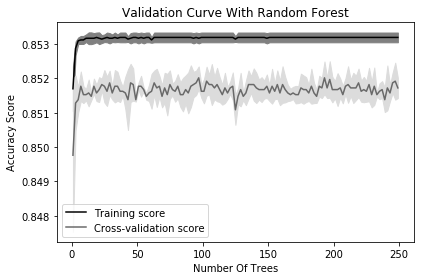

In [0]:
# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show();